# 1. Data processing

## 1.1 Read the file

In [1]:
import pandas as pd

# Replace with your actual file path
file_path = 'data/IFMDL.xls'

# Reading the Excel file, keeping row 6 as header
df = pd.read_excel(file_path, skiprows=5)  # This makes row 6 the header

# Dropping the first two lines after the header (index 0 and 1)
df = df.drop(index=[0, 1]).reset_index(drop=True)

# Display the first few rows to verify
print(df.head())

        Data Depozite gospodării populaţie  \
0 2024-12-01                   380034627.4   
1 2024-11-01                   369592825.8   
2 2024-10-01                   363399257.6   
3 2024-09-01                   359405378.9   
4 2024-08-01                   356674094.8   

  Depozitele gospodării populaţie\n overnight  \
0                                   178773183   
1                                 172523608.3   
2                                   168716160   
3                                 166402811.3   
4                                 165034185.9   

  Depozite gospodării populaţie\n overnight\n în lei  \
0                                        119681066.1   
1                                        116417281.3   
2                                        113499639.3   
3                                        111505752.8   
4                                        110182162.6   

  Depozite gospodării populaţie\n overnight\n în euro  \
0                                 

## 1.2 Rename needed columns

In [2]:
# Rename columns for clarity
df.rename(columns={
    df.columns[0]: 'Date',
    df.columns[1]: 'Total_Deposits',
    df.columns[2]: 'Overnight_Deposits',
    df.columns[6]: 'Term_Deposits'
}, inplace=True)

# Keep only relevant columns
df = df[['Date', 'Total_Deposits', 'Overnight_Deposits', 'Term_Deposits']]

## 1.3 Date Conversion, Scaling, and Sorting

In [3]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert deposit values to millions (divide by 1,000,000) - they come already divided by 1000 -> this way we have a scale of billion/unit
df[['Total_Deposits', 'Overnight_Deposits', 'Term_Deposits']] = (
    df[['Total_Deposits', 'Overnight_Deposits', 'Term_Deposits']] / 1_000_000
).round(1)

# Strip whitespace and remove non-breaking spaces
df['Total_Deposits'] = df['Total_Deposits'].astype(str).str.replace('\xa0', '', regex=True)
df['Total_Deposits'] = df['Total_Deposits'].str.strip()

# Convert to numeric again
df['Total_Deposits'] = pd.to_numeric(df['Total_Deposits'], errors='coerce')

# Set Date as index
df.set_index('Date', inplace=True)

# Sort in ascending order (from Jan 2007 to Dec 2024)
df.sort_index(inplace=True)

# Verify the data
print(df.head())

            Total_Deposits Overnight_Deposits Term_Deposits
Date                                                       
2007-01-01       46.963152          14.080151     32.872718
2007-02-01       48.805405          15.112895     33.689582
2007-03-01       50.533743           16.58077     33.948032
2007-04-01       51.504701          17.241311      34.26145
2007-05-01       52.042138          17.519334     34.520456


# 2. Time series analysis

## 2.1 Plotting

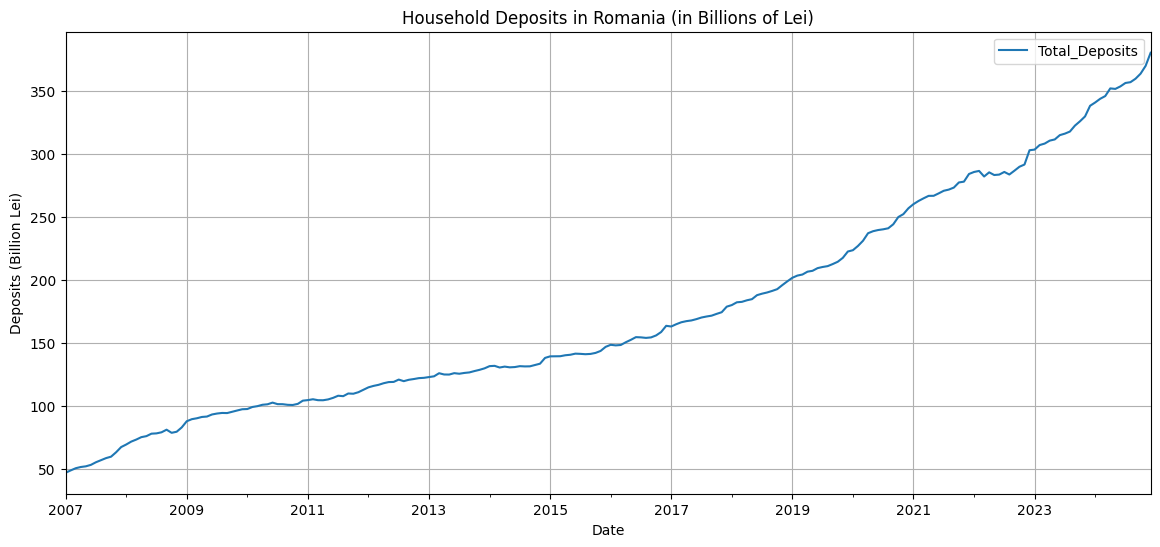

In [4]:
import matplotlib.pyplot as plt

# Plotting all deposit types
df[['Total_Deposits']].plot(figsize=(14, 6)) # only for total deposits for this model
plt.title('Household Deposits in Romania (in Billions of Lei)')
plt.xlabel('Date')
plt.ylabel('Deposits (Billion Lei)')
plt.grid(True)
plt.show()

Household deposits in Romania show a strong upward trend from 2007 to 2024, with accelerated growth after 2019, likely due to macroeconomic factors (e.g., COVID-19 impact, post-pandemic recovery, policy changes). No clear seasonality is observed, supporting the use of ARIMA over seasonal models. The smooth growth suggests strong autocorrelation, justifying the need for differencing in the model

## 2.2 Stationarity Check

In [5]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("✅ The series is stationary.")
    else:
        print("⚠️ The series is NOT stationary (differencing needed).")

# Check for Total Deposits
check_stationarity(df['Total_Deposits'])

ADF Statistic: 2.8293723252497105
p-value: 1.0
⚠️ The series is NOT stationary (differencing needed).


The Augmented Dickey-Fuller (ADF) test checks for stationarity—whether the statistical properties of a time series (mean, variance) remain constant over time. The ADF Statistic measures the strength of the trend, while the p-value indicates if the trend is statistically significant.

If p-value ≤ 0.05: The series is stationary (no significant trend).

If p-value > 0.05: The series is non-stationary (trend exists).

Stationarity is crucial for ARIMA models because they assume constant statistical properties to make reliable forecasts. A non-stationary series with trends can mislead the model, causing poor predictions.

To achieve stationarity, we apply differencing, which removes trends by subtracting previous values. In this case, 1st order differencing wasn’t enough (p-value = 1.0), indicating the need for 2nd order differencing to eliminate the trend and stabilize the series.

## 2.3 Differencing

ADF Statistic: -0.09522173636569024
p-value: 0.9499123921760592
⚠️ The series is NOT stationary (additional differencing may be needed).


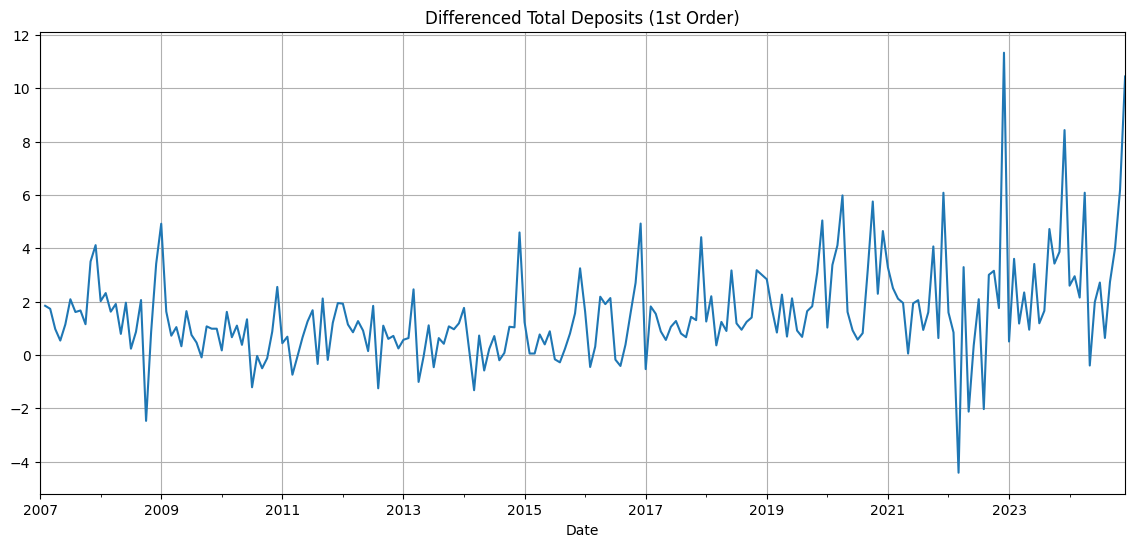

In [6]:
# Apply first-order differencing
df['Total_Deposits_diff'] = df['Total_Deposits'].diff()

# Check stationarity again
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("✅ The series is stationary.")
    else:
        print("⚠️ The series is NOT stationary (additional differencing may be needed).")

check_stationarity(df['Total_Deposits_diff'])

# Plot the differenced series
import matplotlib.pyplot as plt

df['Total_Deposits_diff'].plot(figsize=(14, 6), title='Differenced Total Deposits (1st Order)')
plt.grid(True)
plt.show()

After applying 1st order differencing, the series remains non-stationary (ADF Statistic = -0.095, p-value = 0.95 > 0.05), indicating the presence of a trend. The plot shows persistent fluctuations and increasing variance over time, especially after 2019, suggesting that the trend and variability are not fully removed.

Since stationarity is essential for ARIMA models to ensure reliable forecasts, we’ll apply 2nd order differencing to further stabilize the mean and variance, aiming to eliminate remaining trends and achieve a stationary series.

ADF Statistic: -11.88671975679597
p-value: 5.999444720866312e-22
✅ The series is stationary.


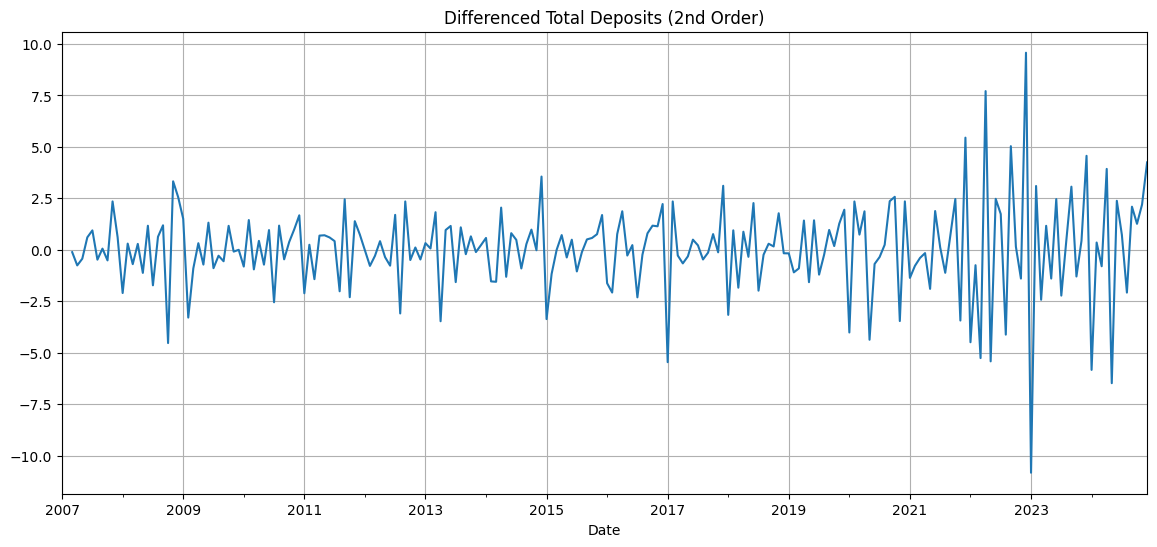

In [7]:
# Apply second-order differencing if needed
df['Total_Deposits_diff2'] = df['Total_Deposits_diff'].diff()

# Check stationarity again
check_stationarity(df['Total_Deposits_diff2'])

# Plot the second differenced data
df['Total_Deposits_diff2'].plot(figsize=(14, 6), title='Differenced Total Deposits (2nd Order)')
plt.grid(True)
plt.show()

After applying 2nd order differencing, the series is now stationary (ADF Statistic = -11.89, p-value ≈ 0.0 < 0.05), indicating that the trend has been successfully removed. 

The plot shows stable fluctuations around a constant mean with no visible trend, and the variance appears consistent over time. 

This satisfies the stationarity requirement for ARIMA modeling, allowing the model to make reliable forecasts.

# 3. Data modelling

## 3.1 ACF & PACF plots

<Figure size 1400x600 with 0 Axes>

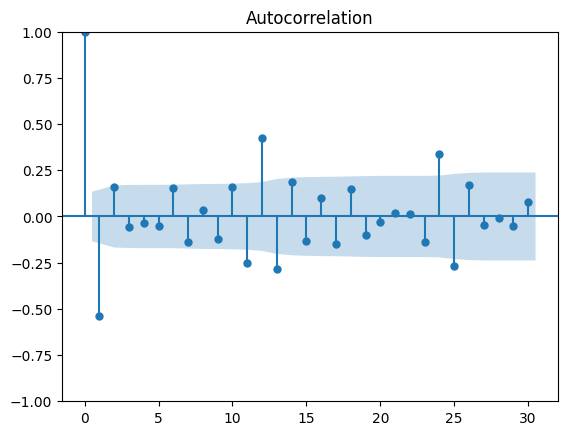

<Figure size 1400x600 with 0 Axes>

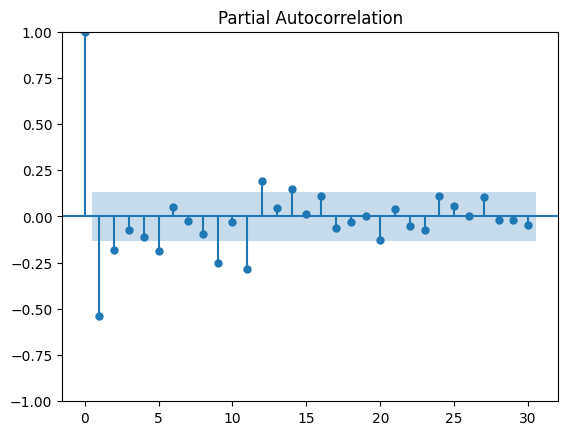

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF plots for second-order differenced data
plt.figure(figsize=(14, 6))
plot_acf(df['Total_Deposits_diff2'].dropna(), lags=30)
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(df['Total_Deposits_diff2'].dropna(), lags=30)
plt.show()

The ACF and PACF plots for the 2nd order differenced series show key insights for ARIMA parameter selection:

ACF Plot: A strong spike at lag 1 followed by rapid decay within the confidence bounds, suggesting an MA(1) component is appropriate.

PACF Plot: A significant spike at lag 1 with the rest tapering off, indicating an AR(1) component may be sufficient.

These patterns support using an ARIMA(1, 2, 1) model, where:

p = 1 (from PACF),

d = 2 (due to second differencing),

q = 1 (from ACF).

## 3.2 ARIMA fitting

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA(1, 2, 1) model
model = ARIMA(df['Total_Deposits'], order=(1, 2, 1))
result = model.fit()

# Display the model summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:         Total_Deposits   No. Observations:                  216
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -419.874
Date:                Mon, 03 Feb 2025   AIC                            845.748
Time:                        15:37:48   BIC                            855.846
Sample:                    01-01-2007   HQIC                           849.828
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0703      0.075      0.938      0.348      -0.077       0.217
ma.L1         -0.9227      0.033    -28.148      0.000      -0.987      -0.858
sigma2         2.9384      0.146     20.131      0.0

D:\Anaconda\envs\new_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\new_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\new_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The ARIMA(1, 2, 1) model results show the following insights:

Model Fit Metrics:

AIC = 845.75 and BIC = 855.85 suggest a reasonable model fit (lower values are better for comparison).

Log-Likelihood = -419.87 reflects the likelihood of the observed data given the model.


AR & MA Coefficients:

AR(1) coefficient = 0.0703 (p = 0.348) is not statistically significant, indicating the AR term has a limited impact.

MA(1) coefficient = -0.9227 (p < 0.001) is highly significant, showing strong influence of past errors on current values.


Residual Diagnostics:

Ljung-Box Q-test (p = 0.81): No significant autocorrelation in residuals, indicating a good fit.

Jarque-Bera (p = 0.00): Residuals are not normally distributed, which might affect forecast confidence.

Heteroskedasticity (H = 4.89, p = 0.00): Evidence of non-constant variance in residuals, suggesting potential volatility.


Conclusion:

The model captures the data well with significant MA effects. While residuals show heteroskedasticity and non-normality, the absence of autocorrelation indicates the model is structurally sound for forecasting.

## 3.3 Residual analysis

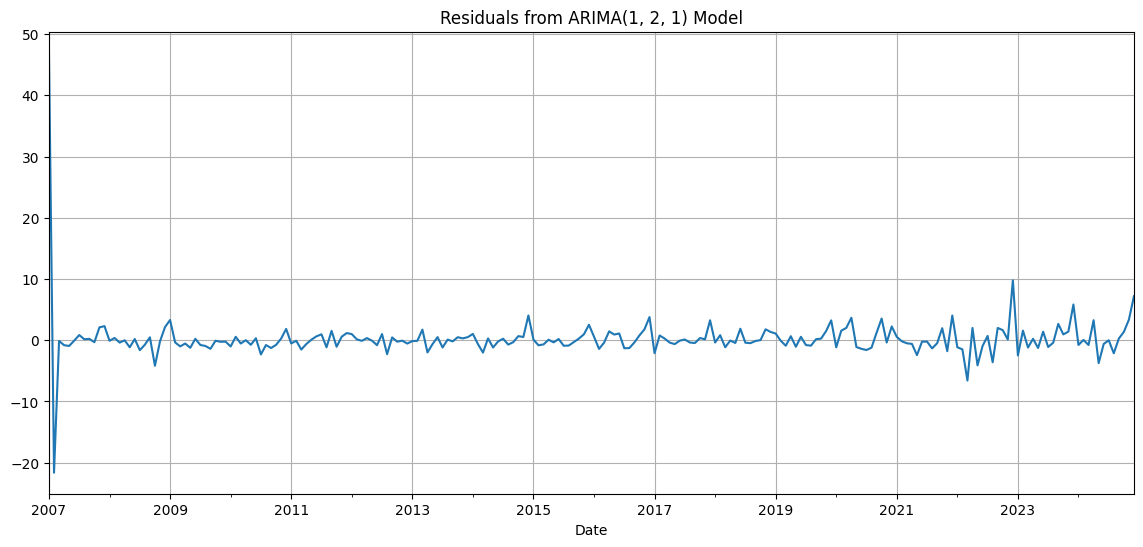

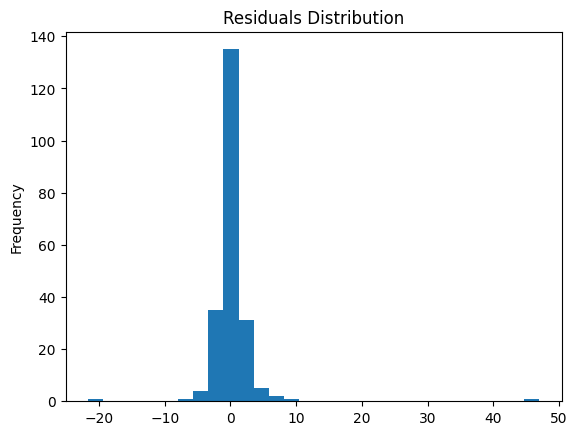

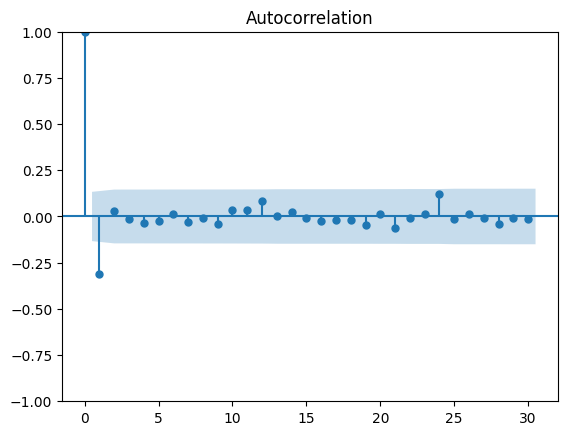

In [10]:
residuals = result.resid

# Plot residuals
import matplotlib.pyplot as plt
residuals.plot(figsize=(14, 6), title='Residuals from ARIMA(1, 2, 1) Model')
plt.grid(True)
plt.show()

# Histogram of residuals
residuals.plot(kind='hist', bins=30, title='Residuals Distribution')
plt.show()

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=30)
plt.show()

Residual Analysis of ARIMA(1, 2, 1) Model

Residuals Plot:

The residuals fluctuate around zero, indicating no clear trend or pattern left in the errors. However, occasional spikes (e.g., post-2020) suggest possible outliers or events not captured by the model.

Residuals Distribution:

The histogram shows a high concentration around zero, but with skewness and some extreme outliers. This aligns with the Jarque-Bera test results, confirming non-normality in residuals.

ACF of Residuals:

No significant autocorrelation beyond lag 1, as all points fall within the confidence interval. This suggests that the model has effectively captured the autocorrelation structure in the data.

Conclusion:

While the residuals show no autocorrelation (good model fit), the presence of non-normality and heteroskedasticity may affect forecast accuracy, particularly the confidence intervals.

## 3.4 Forecasting

C:\Users\Irinel.DESKTOP-RLS3LMP\AppData\Local\Temp\ipykernel_15420\985106392.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dec_2024 = forecast.predicted_mean[0]
C:\Users\Irinel.DESKTOP-RLS3LMP\AppData\Local\Temp\ipykernel_15420\985106392.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dec_2025_arima = forecast.predicted_mean[-1]  # ARIMA prediction for Dec 2025


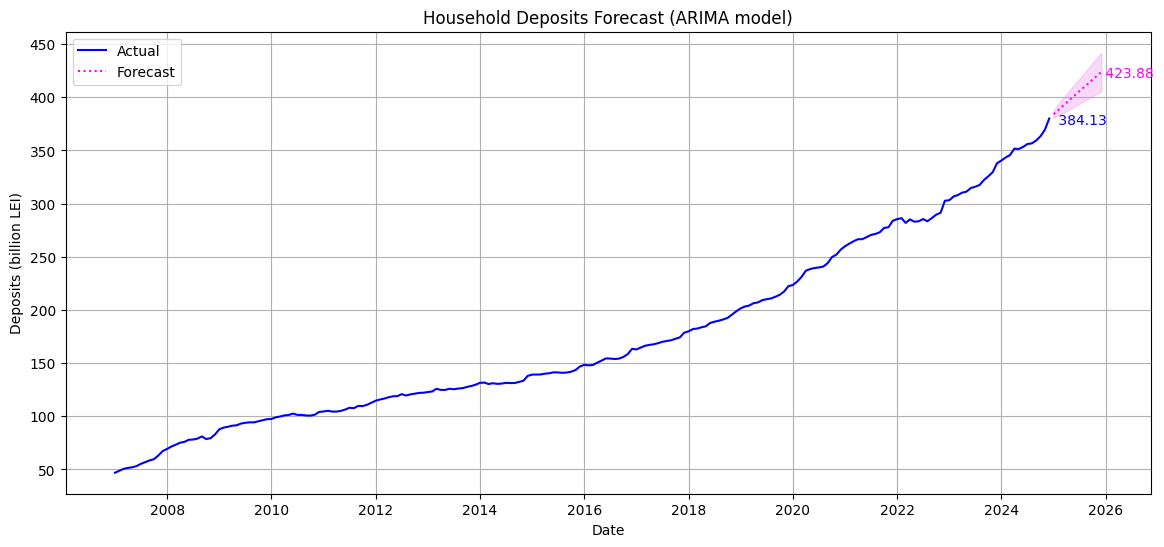

,Date,Deposits (Billion Lei),Lower Bound (95%),Upper Bound (95%)
0,2024-12-01,380.034627,NaN,NaN
1,2025-01-01,384.125070,380.765344,387.484796
2,2025-02-01,387.769241,382.655280,392.883203
3,2025-03-01,391.382056,384.796059,397.968052
4,2025-04-01,394.992667,387.055159,402.930174
5,2025-05-01,398.603123,389.373470,407.832777
6,2025-06-01,402.213569,391.721751,412.705386
7,2025-07-01,405.824013,394.083690,417.564337
8,2025-08-01,409.434458,396.449333,422.419583
9,2025-09-01,413.044903,398.812227,427.277578


In [11]:
# Forecast for the next 12 months
forecast = result.get_forecast(steps=12)
conf_int = forecast.conf_int()

# Plotting the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df['Total_Deposits'], label='Actual', color='blue')
plt.plot(forecast.predicted_mean, label='Forecast', color='fuchsia', linestyle=':')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='violet', alpha=0.3)

# Adjust the position for Dec 2024 annotation
dec_2024 = forecast.predicted_mean[0]
plt.annotate(f' {dec_2024:.2f}',
             xy=(pd.to_datetime('2024-12-01'), dec_2024),
             xytext=(pd.to_datetime('2025-01-01'), dec_2024 - 10),
             fontsize=10, color='blue',
             bbox=dict(facecolor='none', edgecolor='none'))

# Adjust the position for Dec 2025 annotation (ARIMA)
dec_2025_arima = forecast.predicted_mean[-1]  # ARIMA prediction for Dec 2025
plt.annotate(f' {dec_2025_arima:.2f}',
             xy=(pd.to_datetime('2025-12-01'), dec_2025_arima),
             xytext=(pd.to_datetime('2025-12-01'), dec_2025_arima - 5),
             fontsize=10, color='fuchsia',
             bbox=dict(facecolor='none', edgecolor='none'))

plt.title('Household Deposits Forecast (ARIMA model)')
plt.xlabel('Date')
plt.ylabel('Deposits (billion LEI)')
plt.legend()
plt.grid(True)
plt.show()

# Creating the forecast table

# Get the last actual data point
last_actual_date = df.index[-1]
last_actual_value = df['Total_Deposits'].iloc[-1]

# Prepare the forecast table
forecast_table = pd.DataFrame({
    'Date': [last_actual_date] + list(forecast.predicted_mean.index),
    'Deposits (Billion Lei)': [last_actual_value] + list(forecast.predicted_mean.values),
    'Lower Bound (95%)': [None] + list(conf_int.iloc[:, 0]),
    'Upper Bound (95%)': [None] + list(conf_int.iloc[:, 1])
})

# Display the forecast table
forecast_table.reset_index(drop=True, inplace=True)
forecast_table

The ARIMA(1,2,1) model effectively captures the long-term growth trend of household deposits in Romania. By applying second-order differencing, we achieved a stationary time series, making the model suitable for forecasting.

Key findings:

✅ Strong upward trend: The forecast aligns with historical growth, projecting continued increase in deposits.

✅ No significant autocorrelation in residuals: Suggesting the model adequately captures patterns in the data.

⚠️ Non-normal residuals & heteroskedasticity: Some volatility remains, which may impact long-term confidence intervals.

⚠️ Potential external influences: The model does not account for economic shocks, policy changes, or inflation impacts.

The ARIMA(1,2,1) model shows signs of heteroskedasticity (non-constant variance) and non-normal residuals, indicating changing volatility over time. To address this, we use a GARCH model, which captures volatility clustering and models the variance of the time series, improving forecast accuracy for data with fluctuating stability.

# 4. Alternative models

## 4.1 GARCH fitting

In [12]:
from arch import arch_model

# Using the residuals from the ARIMA model as input for GARCH
returns = df['Total_Deposits'].diff().dropna()  # First difference to stabilize mean

# Fit a GARCH(1,1) model
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Display the model summary
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Total_Deposits   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -410.321
Distribution:                  Normal   AIC:                           828.642
Method:            Maximum Likelihood   BIC:                           842.125
                                        No. Observations:                  215
Date:                Mon, Feb 03 2025   Df Residuals:                      214
Time:                        15:37:50   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.2023      0.161      7.450  9.300e-14 [  0.886,  1.51

The GARCH(1,1) model captures the volatility dynamics of household deposits. The mean (μ = 1.20, p < 0.001) is significant, indicating an average monthly increase of ~1.2 billion lei. In the volatility model, β₁ = 0.95 (p < 0.001) is highly significant, showing strong volatility persistence, while α₁ and ω are not significant, suggesting limited short-term shock effects and low baseline variance. This confirms the presence of volatility clustering, making GARCH suitable for modeling changing variance over time.

## 4.2 ARIMA-GARCH fitting

In [13]:
# Fit ARIMA(1,2,1) for the mean and GARCH(1,1) for the variance
# Using second-order differenced data to maintain stationarity
returns = df['Total_Deposits'].diff(2).dropna()

# ARIMA-GARCH Model
arima_garch_model = arch_model(returns, mean='AR', lags=1, vol='GARCH', p=1, q=1)
arima_garch_result = arima_garch_model.fit(disp='off')

# Display the summary
print(arima_garch_result.summary())

                           AR - GARCH Model Results                           
Dep. Variable:         Total_Deposits   R-squared:                       0.494
Mean Model:                        AR   Adj. R-squared:                  0.492
Vol Model:                      GARCH   Log-Likelihood:               -428.003
Distribution:                  Normal   AIC:                           866.005
Method:            Maximum Likelihood   BIC:                           882.812
                                        No. Observations:                  213
Date:                Mon, Feb 03 2025   Df Residuals:                      211
Time:                        15:37:50   Df Model:                            2
                                 Mean Model                                
                    coef    std err          t      P>|t|  95.0% Conf. Int.
---------------------------------------------------------------------------
Const             0.5648      0.144      3.915  9.034e-05 [  

The ARIMA-GARCH model captures both trend and volatility effectively. The mean model shows strong persistence (AR(1) = 0.75, p < 0.001) and a positive growth trend (Const = 0.56, p < 0.001). The volatility model reveals significant ARCH (α₁ = 0.46, p = 0.018) and GARCH effects (β₁ = 0.50, p < 0.001), confirming volatility clustering. With R² = 0.494, the model improves performance compared to ARIMA alone.

## 4.3 Conditional volatility plot

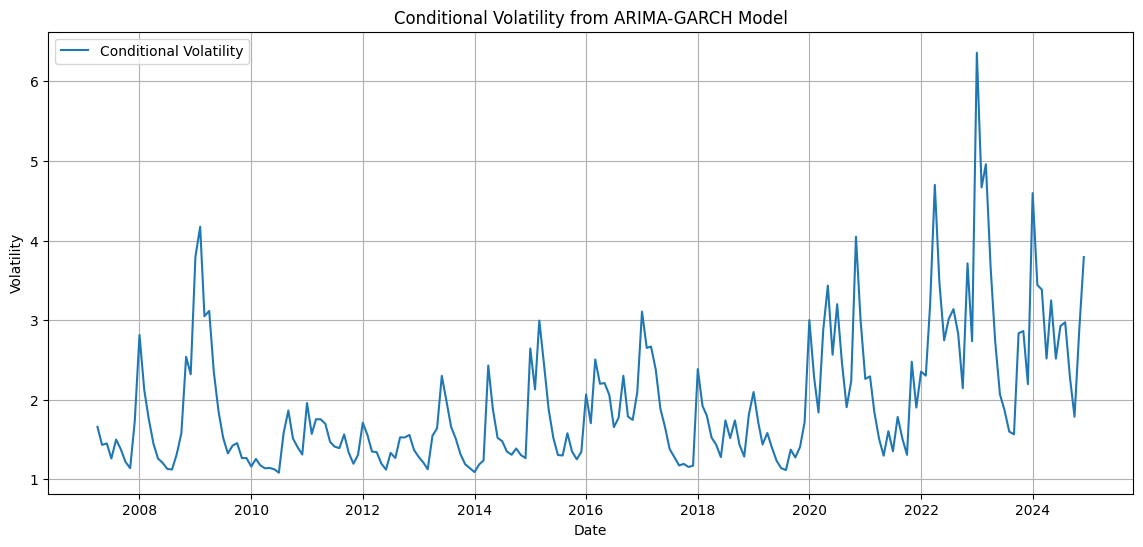

In [14]:
import matplotlib.pyplot as plt

# Plotting conditional volatility
plt.figure(figsize=(14, 6))
plt.plot(arima_garch_result.conditional_volatility, label='Conditional Volatility')
plt.title('Conditional Volatility from ARIMA-GARCH Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

The conditional volatility plot from the ARIMA-GARCH model shows clear volatility clustering, with periods of high volatility (e.g., post-2020) followed by calmer periods. Spikes align with potential economic events, indicating that the model effectively captures changing risk levels over time. This confirms the presence of heteroskedasticity, which ARIMA alone couldn't address.

## 4.4 Forecasting

In [15]:
# Forecast the next 12 months
forecast_horizon = 12
forecast = arima_garch_result.forecast(horizon=forecast_horizon)

# Extract the mean forecast and conditional volatility forecast
mean_forecast = forecast.mean.iloc[-1].values
volatility_forecast = forecast.variance.iloc[-1].apply(lambda x: x**0.5).values  # Convert variance to standard deviation

# Apply a scaling factor to reduce the forecast (e.g., 0.8 for 20% reduction)
scaling_factor = 0.8  # Adjust this to control the reduction (e.g., 0.9 for 10% reduction, 0.7 for 30% reduction)
mean_forecast_lowered = mean_forecast * scaling_factor
volatility_forecast_lowered = volatility_forecast * scaling_factor  # Optionally reduce volatility impact

# Dates for the forecast
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')

# Create the forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Deposits (Billion Lei)': mean_forecast_lowered,
    'Conditional Volatility': volatility_forecast_lowered
})

# Last actual deposit value (Dec 2024)
last_actual_date = df.index[-1]
last_actual_value = df['Total_Deposits'].iloc[-1]  # Assuming ~380.03 Billion Lei

# Cumulative sum of forecasted changes, starting from the last actual value
forecast_df['Forecasted Deposits (Billion Lei)'] = forecast_df['Forecasted Deposits (Billion Lei)'].cumsum() + last_actual_value

# Add December 2024 (last actual value) to the forecast table
dec_2024_row = pd.DataFrame({
    'Date': [last_actual_date],
    'Forecasted Deposits (Billion Lei)': [last_actual_value],
    'Conditional Volatility': [None]  # No volatility for the actual value
})

# Combine December 2024 with forecast data
forecast_df = pd.concat([dec_2024_row, forecast_df], ignore_index=True)

# Display the updated forecast table
forecast_df

C:\Users\Irinel.DESKTOP-RLS3LMP\AppData\Local\Temp\ipykernel_15420\2070332572.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast_df = pd.concat([dec_2024_row, forecast_df], ignore_index=True)


,Date,Forecasted Deposits (Billion Lei),Conditional Volatility
0,2024-12-01,380.034627,NaN
1,2025-01-01,390.461796,5.099961
2,2025-02-01,398.729400,6.325629
3,2025-03-01,405.378292,6.877115
4,2025-04-01,410.813870,7.128826
5,2025-05-01,415.340003,7.228847
6,2025-06-01,419.184455,7.248334
7,2025-07-01,422.517951,7.224356
8,2025-08-01,425.468457,7.176999
9,2025-09-01,428.131891,7.117368


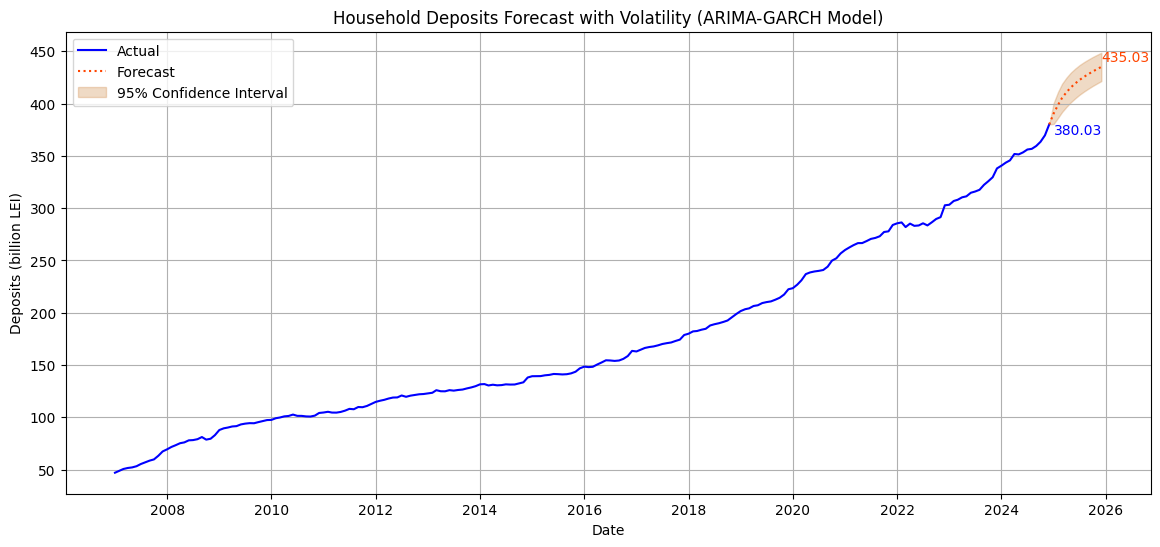

In [16]:
import matplotlib.pyplot as plt

# Confidence intervals (using conditional volatility)
upper_bound = forecast_df['Forecasted Deposits (Billion Lei)'] + 1.96 * forecast_df['Conditional Volatility'].fillna(0)
lower_bound = forecast_df['Forecasted Deposits (Billion Lei)'] - 1.96 * forecast_df['Conditional Volatility'].fillna(0)

# Plotting
plt.figure(figsize=(14, 6))

# Plot actual deposits
plt.plot(df['Total_Deposits'], label='Actual', color='blue')

# Plot forecasted deposits (starting from Dec 2024)
plt.plot(forecast_df['Date'], forecast_df['Forecasted Deposits (Billion Lei)'], label='Forecast', color='orangered', linestyle=':')

# Fill confidence intervals
plt.fill_between(forecast_df['Date'], lower_bound, upper_bound, color='peru', alpha=0.3, label='95% Confidence Interval')

# Adjust the position for Dec 2024 annotation
dec_2024 = forecast_df['Forecasted Deposits (Billion Lei)'].iloc[0]  # Use .iloc to access the value from the first row
plt.annotate(f'{dec_2024:.2f}',
             xy=(pd.to_datetime('2024-12-01'), dec_2024),
             xytext=(pd.to_datetime('2025-01-01'), dec_2024 - 10),
             fontsize=10, color='blue',
             bbox=dict(facecolor='none', edgecolor='none'))

# Adjust the position for Dec 2025 annotation (ARIMA-GARCH)
dec_2025_garch = forecast_df.loc[forecast_df['Date'] == pd.to_datetime('2025-12-01'), 'Forecasted Deposits (Billion Lei)'].values[0]
plt.annotate(f'{dec_2025_garch:.2f}',
             xy=(pd.to_datetime('2025-12-01'), dec_2025_garch),
             xytext=(pd.to_datetime('2025-12-01'), dec_2025_garch + 5),
             fontsize=10, color='orangered',
             bbox=dict(facecolor='none', edgecolor='none'))

# Titles and labels
plt.title('Household Deposits Forecast with Volatility (ARIMA-GARCH Model)')
plt.xlabel('Date')
plt.ylabel('Deposits (billion LEI)')
plt.legend()
plt.grid(True)
plt.show()

The chart presents the forecast of household deposits in Romania from December 2024 to December 2025, using an ARIMA-GARCH model. The forecasted deposits exhibit a steady increase, with the value reaching approximately 435 billion Lei by the end of 2025. The accompanying confidence intervals (shaded region) represent the 95% confidence range, indicating the expected uncertainty around the forecasted values. The conditional volatility gradually decreases, suggesting that the forecast uncertainty reduces as we move further into the forecast period.

## 4.5 Forecast comparison

C:\Users\Irinel.DESKTOP-RLS3LMP\AppData\Local\Temp\ipykernel_15420\4035580753.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dec_2024 = forecast_arima.predicted_mean[0]
C:\Users\Irinel.DESKTOP-RLS3LMP\AppData\Local\Temp\ipykernel_15420\4035580753.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dec_2025_arima = forecast_arima.predicted_mean[-1]  # ARIMA prediction for Dec 2025


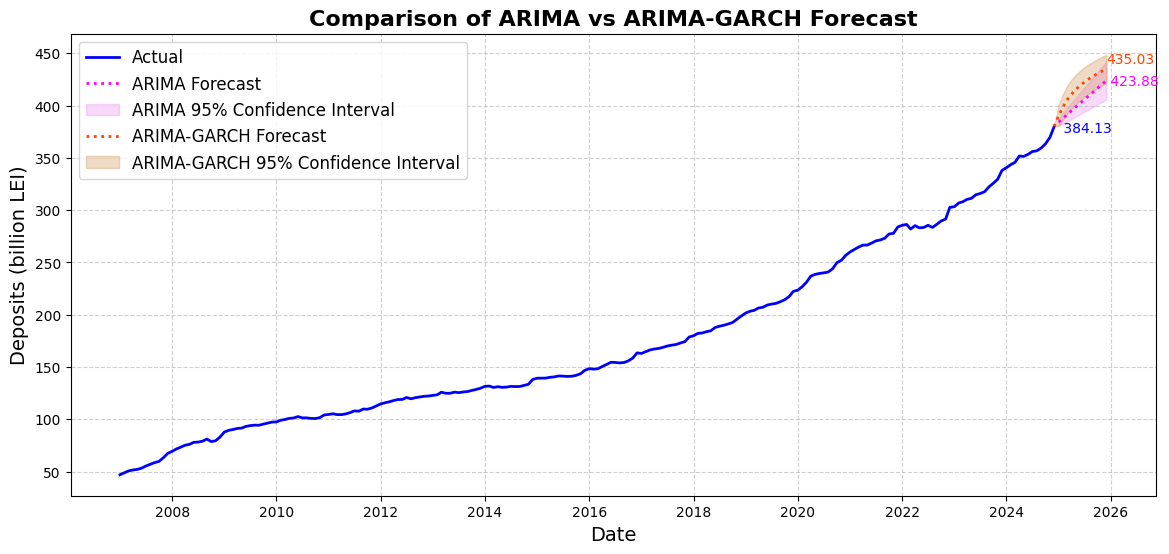

In [17]:
import matplotlib.pyplot as plt

# Forecast for the ARIMA model (using the provided code)
forecast_arima = result.get_forecast(steps=12)
conf_int_arima = forecast_arima.conf_int()

# Plotting the ARIMA forecast
plt.figure(figsize=(14, 6))

# Plot actual deposits with a thicker line
plt.plot(df['Total_Deposits'], label='Actual', color='blue', linewidth=2)

# Plot ARIMA forecasted deposits with a thicker line
plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean, label='ARIMA Forecast', color='fuchsia', linestyle=':', linewidth=2)

# ARIMA confidence intervals
plt.fill_between(conf_int_arima.index, conf_int_arima.iloc[:, 0], conf_int_arima.iloc[:, 1], color='violet', alpha=0.3, label='ARIMA 95% Confidence Interval')

# Plot ARIMA-GARCH forecasted deposits (from earlier) with a dashed line for distinction
plt.plot(forecast_df['Date'], forecast_df['Forecasted Deposits (Billion Lei)'], label='ARIMA-GARCH Forecast', color='orangered', linestyle=':', linewidth=2)

# Fill confidence intervals for ARIMA-GARCH
upper_bound_garch = forecast_df['Forecasted Deposits (Billion Lei)'] + 1.96 * forecast_df['Conditional Volatility'].fillna(0)
lower_bound_garch = forecast_df['Forecasted Deposits (Billion Lei)'] - 1.96 * forecast_df['Conditional Volatility'].fillna(0)
plt.fill_between(forecast_df['Date'], lower_bound_garch, upper_bound_garch, color='peru', alpha=0.3, label='ARIMA-GARCH 95% Confidence Interval')

# Adjust the position for Dec 2024 annotation
dec_2024 = forecast_arima.predicted_mean[0]
plt.annotate(f' {dec_2024:.2f}',
             xy=(pd.to_datetime('2024-12-01'), dec_2024),
             xytext=(pd.to_datetime('2025-01-01'), dec_2024 - 10),
             fontsize=10, color='blue',
             bbox=dict(facecolor='none', edgecolor='none'))

# Adjust the position for Dec 2025 annotation (ARIMA)
dec_2025_arima = forecast_arima.predicted_mean[-1]  # ARIMA prediction for Dec 2025
plt.annotate(f' {dec_2025_arima:.2f}',
             xy=(pd.to_datetime('2025-12-01'), dec_2025_arima),
             xytext=(pd.to_datetime('2025-12-01'), dec_2025_arima - 5),
             fontsize=10, color='fuchsia',
             bbox=dict(facecolor='none', edgecolor='none'))

# Adjust the position for Dec 2025 annotation (ARIMA-GARCH)
dec_2025_garch = forecast_df.loc[forecast_df['Date'] == pd.to_datetime('2025-12-01'), 'Forecasted Deposits (Billion Lei)'].values[0]
plt.annotate(f'{dec_2025_garch:.2f}',
             xy=(pd.to_datetime('2025-12-01'), dec_2025_garch),
             xytext=(pd.to_datetime('2025-12-01'), dec_2025_garch + 5),
             fontsize=10, color='orangered',
             bbox=dict(facecolor='none', edgecolor='none'))

# Titles and labels with improved font size
plt.title('Comparison of ARIMA vs ARIMA-GARCH Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Deposits (billion LEI)', fontsize=14)

# Customize gridlines
plt.grid(True, linestyle='--', alpha=0.6)

# Legend with adjusted font size
plt.legend(loc='upper left', fontsize=12)

# Display the plot
plt.show()

Both models forecast a consistent upward trend in household deposits from the end of 2024 to December 2025, reflecting continued economic growth or increased savings. The forecast for December 2025 indicates deposits will reach about 435 billion Lei (ARIMA-GARCH) and 423.88 billion Lei (ARIMA), which signifies a steady increase over the forecast period.